In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import sys
import os

# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import dem
from dem.models.components.mlp import MyMLP


from dem.energies.gmm_energy import GMM

/home/mila/b/bosejoey/scratch/micromamba/envs/dem/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:

from dem.models.components.sde_integration import integrate_ode
from dem.models.components.clipper import Clipper
from dem.models.components.noise_schedules import LinearNoiseSchedule
from dem.energies.base_prior import Prior
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.000004, sigma_max=0.4)
beta = torch.tensor(0.2).to(device)
noise_schedule = LinearNoiseSchedule(beta)
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)

prior = Prior(dim=2, device=device, scale = noise_schedule.h(1) ** 0.5)

In [5]:
import abc

class Schedule_base(metaclass=abc.ABCMeta):
    """Abstract base class from which all log densities should inherit."""

    def __init__(self):
        pass

    def __call__(self, x):
        outf = self.tt(x)
        doutf = self.dtt(x)
        
        return outf, doutf

    @abc.abstractmethod
    def tt(self, x): 
        pass

    @abc.abstractmethod
    def dtt(self, x): 
        pass

class CosSchedule(Schedule_base):
    def __init__(self):
        super().__init__()
    def tt(self,t):
        out = 0.5*(1.0-torch.cos(torch.pi*t))
        return out

    def dtt(self,t):
        out = (0.5*torch.pi*torch.sin(torch.pi*t))
        return out

class LinearSchedule(Schedule_base):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def tt(self, t):
        out = t 
        return out

    def dtt(self, t):
        out = torch.tensor(1.0).to(self.device)
        return out

In [6]:
import torch
from torch.autograd.functional import jacobian
import abc

class ReverseODE(torch.nn.Module):
    def __init__(self, drift, noise_schedule, prior, target, clipper, schedule, resample_threshold=0.98):
        super().__init__()
        self.drift = drift
        self.noise_schedule = noise_schedule
        self.prior = prior
        self.target = target
        self.clipper = clipper
        self.schedule = schedule
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resample_threshold = resample_threshold
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            return self.drift(t, x)
        
    def divergence(self, t, x, vectorfield):
        # compute the divergence of the flow field
        def _func_sum(t_in, x_in):
            return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
        out= jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
        spatial_grad = out[1]
        div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
        return div
    
    def energy_interpolation(self, t, x):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            energy_interpolation = outf * logtarget + (1-outf) * logprior
            return energy_interpolation.squeeze()
        
    def log_weight_step(self, w, x, t, dt):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            partial_Ht = - (doutf * logtarget  - doutf * logprior)
           
            transport_div = self.divergence(t, x, self.drift)
            nabla_Ht = jacobian(self.energy_interpolation, (t, x),create_graph =True,vectorize=True)[1]
            nabla_Ht_div = nabla_Ht.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)

        term1 = (self.drift(t, x) * nabla_Ht_div[:, None]).sum(axis=1)
        
        # Equation in Algo 1 of NETS paper
        dw = (-partial_Ht - term1 + transport_div) * dt
        w = w + dw
        return w
    
    def resample(self, samples, weights):
        # Check if weights are blowing up (using effective sample size as a metric)
        # Calculate effective sample size
        ess = torch.exp(weights).sum()**2 / torch.exp(2 * weights).sum()
        ess_ratio = ess / weights.shape[0]
        
        # Only resample if effective sample size is above threshold (e.g., 0.5)
        # This prevents resampling when weights are degenerate
        if ess_ratio > self.resample_threshold:
            # Convert weights to probabilities (normalize)
            # Add small epsilon to avoid division by zero
            epsilon = 1e-8
            probs = torch.exp(weights) + epsilon
            probs = probs / probs.sum()
            
            # Perform importance sampling resampling
            # Sample indices based on weights
            num_samples = weights.shape[0]
            indices = torch.multinomial(probs, num_samples, replacement=True)
            
            # Resample the final particles based on the sampled indices
            resampled_samples = samples[indices]
            weights = torch.zeros_like(weights)
        else:
            resampled_samples = samples
            weights = weights

        return resampled_samples, weights
    
    def euler_step(self, t, x, dt):
        drift = self.f(t, x) * dt
        x = x + drift
        return x
    
    def sample(self, x0, dt, end_time, device=None, num_samples=None, compute_weight=False):
        """
        Sample from the ODE using Euler method.
        
        Args:
            x0: initial positions
            num_steps: number of integration steps
            dt: time step size
            device: device to run on
            
        Returns:
            samples: trajectory of samples
        """

        if device is None:
            device = x0.device
        
        if x0 is None:
            x = self.prior.sample(num_samples)
        else:
            x = x0

        samples = [x]
        w = torch.zeros(x.shape[0]).to(self.device)
        weights = [w]
        start_time = torch.tensor(0.0).to(self.device)
        delta = end_time - start_time
        num_integration_steps = int(torch.abs(delta) / dt)
        times = torch.linspace(start_time, end_time, num_integration_steps + 1, device=x.device)[:-1]
       
        for t in times:
            x = self.euler_step(t, x, dt)
            if compute_weight:
                w = self.log_weight_step(w, x, t, dt)
                x, w = self.resample(x, w)
                weights.append(w)

            samples.append(x)
        
        return torch.stack(samples)


class LangevinSDE(torch.nn.Module):
    """
    Langevin SDE implementation for sampling from energy functions.
    
    The Langevin SDE is given by:
    dx = -∇E(x)dt + √(2β) dW
    
    where E(x) is the energy function, β is the inverse temperature,
    and W is a Wiener process.
    """
    
    def __init__(self, beta=1.0, schedule=None, target=None, prior=None, vel=None, clipper=None, resample_threshold=0.98):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.beta = torch.tensor(beta).to(self.device)
        self.schedule = schedule
        self.target = target
        self.prior = prior
        self.vel = vel
        self.clipper = clipper
        self.resample_threshold = resample_threshold
    
    def f(self, t, x):
        """
        Drift term: f(t, x) = -∇E(x)
        
        Args:
            t: time (not used in Langevin dynamics)
            x: current position
            
        Returns:
            drift: -∇E(x)
        """
        
        with torch.enable_grad():
            outf, doutf = self.schedule(t)
            x.requires_grad_(True)
            energy_interpolation = outf * self.target(x) + (1-outf) * self.prior.log_prob(x)
            nabla_Ht = torch.autograd.grad(energy_interpolation.sum(), x, create_graph=True)[0]
            nabla_Ht = self.clipper.clip_scores(nabla_Ht)
            drift = nabla_Ht
            if self.vel is not None:    
                transport_drift = self.vel(t, x)
            else:
                transport_drift = torch.zeros_like(x)
        return drift + transport_drift
    
    def g(self, x):
        """
        Diffusion term: g(t, x) = √(2β)
        
        Args:
            t: time (not used in Langevin dynamics)
            x: current position
            
        Returns:
            diffusion: √(2β) * ones_like(x)
        """
        diffusion = torch.sqrt(2.0 * self.beta) * torch.ones_like(x)
        return diffusion
    
    def divergence(self, t, x, vectorfield):
        # compute the divergence of the flow field
        def _func_sum(t_in, x_in):
            return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
        out= jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
        spatial_grad = out[1]
        div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
        return div

    def euler_maruyama_step(self, t, x, dt):
        t = t * torch.ones(x.shape[0]).to(self.device)
        drift = self.f(t, x)
        diffusion = self.g(x)
        dW = torch.randn_like(x) * torch.sqrt(dt)
        x = x + drift * dt + diffusion * dW
        return x
    
    def energy_interpolation(self, t, x):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            energy_interpolation = outf * logtarget + (1-outf) * logprior
            return energy_interpolation.squeeze()
        
    def log_weight_step(self, w, x, t, dt):
        with torch.enable_grad():
            t = t * torch.ones(x.shape[0]).to(self.device)
            x.requires_grad_(True)
            outf, doutf = self.schedule(t)
            logtarget = self.target(x)
            logprior = self.prior.log_prob(x)
            partial_Ht = - (doutf * logtarget  - doutf * logprior)
           
            transport_div = self.divergence(t, x, self.vel)
            nabla_Ht = jacobian(self.energy_interpolation, (t, x),create_graph =True,vectorize=True)[1]
            nabla_Ht_div = nabla_Ht.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)

        term1 = (self.vel(t, x) * nabla_Ht_div[:, None]).sum(axis=1)
        
        # Equation in Algo 1 of NETS paper
        dw = (-partial_Ht - term1 + transport_div) * dt
        w = w + dw
        return w
    
    def resample(self, samples, weights):
        # Check if weights are blowing up (using effective sample size as a metric)
        # Calculate effective sample size
        ess = torch.exp(weights).sum()**2 / torch.exp(2 * weights).sum()
        ess_ratio = ess / weights.shape[0]
        
        # Only resample if effective sample size is above threshold (e.g., 0.5)
        # This prevents resampling when weights are degenerate
        if ess_ratio > self.resample_threshold:
            # Convert weights to probabilities (normalize)
            # Add small epsilon to avoid division by zero
            epsilon = 1e-8
            probs = torch.exp(weights) + epsilon
            probs = probs / probs.sum()
            
            # Perform importance sampling resampling
            # Sample indices based on weights
            num_samples = weights.shape[0]
            indices = torch.multinomial(probs, num_samples, replacement=True)
            
            # Resample the final particles based on the sampled indices
            resampled_samples = samples[indices]
            weights = torch.zeros_like(weights)
        else:
            resampled_samples = samples
            weights = weights

        return resampled_samples, weights
    
    def sample(self, x0, dt, end_time, device=None, num_samples=None, compute_weight=False):
        """
        Sample from the Langevin SDE using Euler-Maruyama method.
        
        Args:
            x0: initial positions
            num_steps: number of integration steps
            dt: time step size
            device: device to run on
            
        Returns:
            samples: trajectory of samples
        """

        if device is None:
            device = x0.device
        
        if x0 is None:
            x = self.prior.sample(num_samples)
        else:
            x = x0

        samples = [x]
        w = torch.zeros(x.shape[0]).to(self.device)
        weights = [w]
        start_time = torch.tensor(0.0).to(self.device)
        delta = end_time - start_time
        num_integration_steps = int(torch.abs(delta) / dt)
        times = torch.linspace(start_time, end_time, num_integration_steps + 1, device=x.device)[:-1]
       
        for t in times:
            x = self.euler_maruyama_step(t, x, dt)
            if compute_weight:
                w = self.log_weight_step(w, x, t, dt)
                x, w = self.resample(x, w)
                weights.append(w)

            samples.append(x)
        
        return torch.stack(samples)

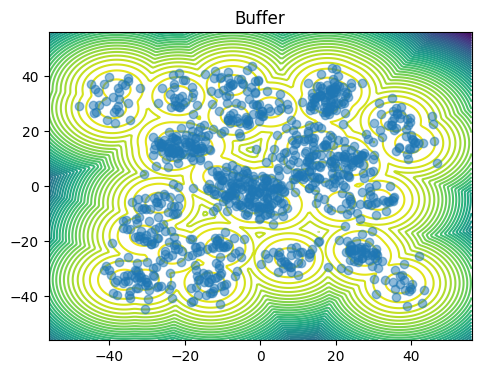

In [7]:
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)

vectorfield = MyMLP().to(device)
optimizer = Adam(vectorfield.parameters(), lr=1e-3)
weighted = False
schedule = LinearSchedule()
langevin_sde = LangevinSDE(beta=1.0, prior=prior, target=target, clipper=clipper, schedule=schedule)

dt = torch.tensor(1.0 / 512).to(device)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
samples = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_000, compute_weight=False)
samples_energy = target(samples[-1])
target.get_dataset_fig(target.unnormalize(samples[-1]))
plt.show()


In [8]:
def divergence(t, x, vectorfield):
    # compute the divergence of the flow field
    def _func_sum(t_in, x_in):
        return vectorfield(t_in, x_in).sum(dim=0) # sum over the batches
    out=jacobian(_func_sum, (t, x),create_graph =True,vectorize=True)
    spatial_grad = out[1]
    div = spatial_grad.diagonal(offset=0, dim1=-1, dim2=-3).sum(-1)
    return div

def compute_pf_loss(x, t, schedule, target, prior, vectorfield):    
    outf, doutf = schedule(t)
    x.requires_grad_(True)
    logtarget = target(x)
    dlogtarget = -1 * torch.autograd.grad(logtarget.sum(), x, create_graph=True)[0]
    logprior = prior.log_prob(x)
    dlogprior = - 1* torch.autograd.grad(logprior.sum(), x, create_graph=True)[0]
    score = outf * dlogtarget + (1-outf) * dlogprior
    score = clipper.clip_scores(score)  

    t_repeat = t.repeat(x.shape[0], 1)
    vel = vectorfield(t_repeat, x)
    div = divergence(t_repeat, x, vectorfield)
    inner_prod = (score*vel).sum(axis=1)

    term1 = (inner_prod - div).pow(2)
    partial_Ht = - (doutf * logtarget  - doutf * logprior)
    nabla_partial_Ht = torch.autograd.grad(partial_Ht.sum(), x, create_graph=True)[0]
    
    term2 = 2* (nabla_partial_Ht.squeeze() * vel).sum(axis=1)

    loss = (term1 + term2)

    return loss

def generate_samples_ode(reverse_ode, num_samples):
    x = prior.sample(num_samples)
    delta = t_end - t_init
    num_integration_steps = int(torch.abs(delta) / dt)
    times = torch.linspace(t_init, t_end, num_integration_steps + 1, device=device)[:-1]
    for t in times:
        drift = reverse_ode.f(t, x) * dt
        x = x + drift
    return x

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Time 0.000000 | Loss 2.270222
Epoch 0 | Time 0.001953 | Loss -24.260513
Epoch 0 | Time 0.003906 | Loss -40.830818
Epoch 0 | Time 0.005859 | Loss -57.260593
Epoch 0 | Time 0.007812 | Loss -86.128098
Epoch 0 | Time 0.009766 | Loss -108.958847
Epoch 0 | Time 0.011719 | Loss -98.197769
Epoch 0 | Time 0.013672 | Loss -130.432755
Epoch 0 | Time 0.015625 | Loss -156.213135
Epoch 0 | Time 0.017578 | Loss -158.795563
Epoch 0 | Time 0.019531 | Loss -133.650162
Epoch 0 | Time 0.021484 | Loss -136.131836
Epoch 0 | Time 0.023438 | Loss -110.643661
Epoch 0 | Time 0.025391 | Loss -58.838432
Epoch 0 | Time 0.027344 | Loss -66.012993
Epoch 0 | Time 0.029297 | Loss -64.700348
Epoch 0 | Time 0.031250 | Loss -48.306137
Epoch 0 | Time 0.033203 | Loss -40.039955
Epoch 0 | Time 0.035156 | Loss -42.114677
Epoch 0 | Time 0.037109 | Loss -46.888603
Epoch 0 | Time 0.039062 | Loss -47.219437
Epoch 0 | Time 0.041016 | Loss -34.264217
Epoch 0 | Time 0.042969 | Loss -37.564018
Epoch 0 | Time 0.044922 | Los

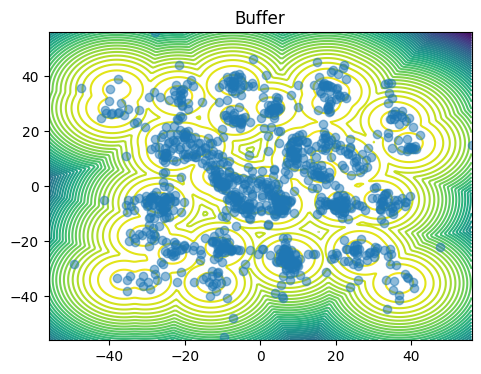

  1%|          | 1/100 [00:08<14:11,  8.60s/it]

Epoch 1 | Time 0.000000 | Loss -66.195763
Epoch 1 | Time 0.001953 | Loss -74.377014
Epoch 1 | Time 0.003906 | Loss -94.171936
Epoch 1 | Time 0.005859 | Loss -127.723297
Epoch 1 | Time 0.007812 | Loss -175.007507
Epoch 1 | Time 0.009766 | Loss -227.947357
Epoch 1 | Time 0.011719 | Loss -257.568695
Epoch 1 | Time 0.013672 | Loss -245.212311
Epoch 1 | Time 0.015625 | Loss -237.632629
Epoch 1 | Time 0.017578 | Loss -188.944550
Epoch 1 | Time 0.019531 | Loss -155.207336
Epoch 1 | Time 0.021484 | Loss -109.239090
Epoch 1 | Time 0.023438 | Loss -131.969269
Epoch 1 | Time 0.025391 | Loss -139.044037
Epoch 1 | Time 0.027344 | Loss -111.012115
Epoch 1 | Time 0.029297 | Loss -106.391655
Epoch 1 | Time 0.031250 | Loss -77.722603
Epoch 1 | Time 0.033203 | Loss -84.043655
Epoch 1 | Time 0.035156 | Loss -82.740685
Epoch 1 | Time 0.037109 | Loss -75.495773
Epoch 1 | Time 0.039062 | Loss -65.506256
Epoch 1 | Time 0.041016 | Loss -72.638901
Epoch 1 | Time 0.042969 | Loss -62.959534
Epoch 1 | Time 0.0449

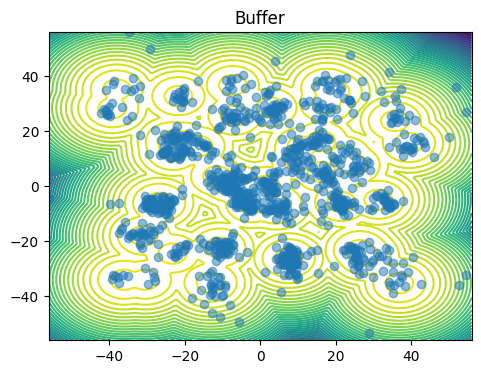

  2%|▏         | 2/100 [00:17<14:02,  8.60s/it]

Epoch 2 | Time 0.000000 | Loss -80.239716
Epoch 2 | Time 0.001953 | Loss -89.281143
Epoch 2 | Time 0.003906 | Loss -108.047272
Epoch 2 | Time 0.005859 | Loss -134.347870
Epoch 2 | Time 0.007812 | Loss -172.182480
Epoch 2 | Time 0.009766 | Loss -210.259125
Epoch 2 | Time 0.011719 | Loss -238.089355
Epoch 2 | Time 0.013672 | Loss -243.874603
Epoch 2 | Time 0.015625 | Loss -227.116425
Epoch 2 | Time 0.017578 | Loss -222.896317
Epoch 2 | Time 0.019531 | Loss -208.035339
Epoch 2 | Time 0.021484 | Loss -132.836304
Epoch 2 | Time 0.023438 | Loss -100.790703
Epoch 2 | Time 0.025391 | Loss -102.085197
Epoch 2 | Time 0.027344 | Loss -102.609734
Epoch 2 | Time 0.029297 | Loss -117.699585
Epoch 2 | Time 0.031250 | Loss -95.744881
Epoch 2 | Time 0.033203 | Loss -82.700806
Epoch 2 | Time 0.035156 | Loss -79.692200
Epoch 2 | Time 0.037109 | Loss -80.071075
Epoch 2 | Time 0.039062 | Loss -71.213287
Epoch 2 | Time 0.041016 | Loss -57.907001
Epoch 2 | Time 0.042969 | Loss -57.744873
Epoch 2 | Time 0.044

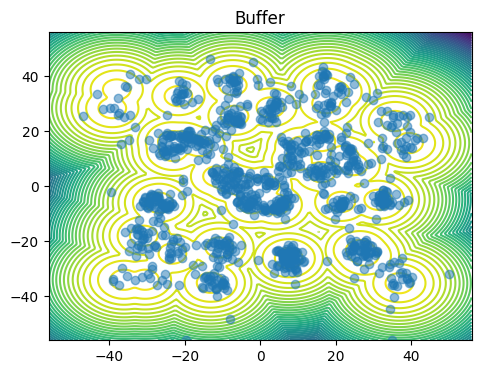

  3%|▎         | 3/100 [00:25<13:27,  8.33s/it]

Epoch 3 | Time 0.000000 | Loss -79.546799
Epoch 3 | Time 0.001953 | Loss -90.516815
Epoch 3 | Time 0.003906 | Loss -107.853226
Epoch 3 | Time 0.005859 | Loss -128.908905
Epoch 3 | Time 0.007812 | Loss -156.126389
Epoch 3 | Time 0.009766 | Loss -197.988800
Epoch 3 | Time 0.011719 | Loss -223.705124
Epoch 3 | Time 0.013672 | Loss -228.885254
Epoch 3 | Time 0.015625 | Loss -213.617386
Epoch 3 | Time 0.017578 | Loss -188.795364
Epoch 3 | Time 0.019531 | Loss -176.592163
Epoch 3 | Time 0.021484 | Loss -159.849213
Epoch 3 | Time 0.023438 | Loss -148.737305
Epoch 3 | Time 0.025391 | Loss -127.605301
Epoch 3 | Time 0.027344 | Loss -105.877991
Epoch 3 | Time 0.029297 | Loss -114.286667
Epoch 3 | Time 0.031250 | Loss -90.479080
Epoch 3 | Time 0.033203 | Loss -88.794983
Epoch 3 | Time 0.035156 | Loss -93.863617
Epoch 3 | Time 0.037109 | Loss -84.426208
Epoch 3 | Time 0.039062 | Loss -70.466019
Epoch 3 | Time 0.041016 | Loss -67.920479
Epoch 3 | Time 0.042969 | Loss -69.044449
Epoch 3 | Time 0.044

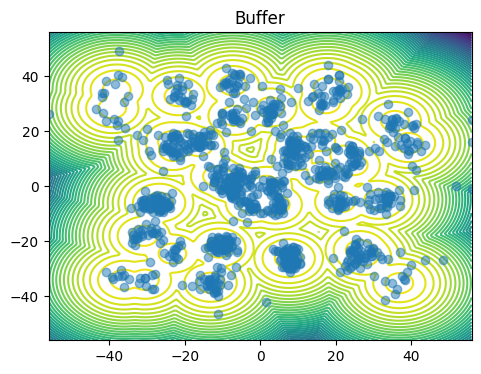

  4%|▍         | 4/100 [00:33<13:17,  8.31s/it]

Epoch 4 | Time 0.000000 | Loss -98.623512
Epoch 4 | Time 0.001953 | Loss -107.024124
Epoch 4 | Time 0.003906 | Loss -131.830841
Epoch 4 | Time 0.005859 | Loss -164.152374
Epoch 4 | Time 0.007812 | Loss -207.708923
Epoch 4 | Time 0.009766 | Loss -240.383820
Epoch 4 | Time 0.011719 | Loss -281.759460
Epoch 4 | Time 0.013672 | Loss -278.700134
Epoch 4 | Time 0.015625 | Loss -249.729645
Epoch 4 | Time 0.017578 | Loss -216.094543
Epoch 4 | Time 0.019531 | Loss -191.013763
Epoch 4 | Time 0.021484 | Loss -175.214874
Epoch 4 | Time 0.023438 | Loss -133.466431
Epoch 4 | Time 0.025391 | Loss -110.070854
Epoch 4 | Time 0.027344 | Loss -124.145218
Epoch 4 | Time 0.029297 | Loss -128.434082
Epoch 4 | Time 0.031250 | Loss -120.592346
Epoch 4 | Time 0.033203 | Loss -106.793900
Epoch 4 | Time 0.035156 | Loss -100.447266
Epoch 4 | Time 0.037109 | Loss -97.035812
Epoch 4 | Time 0.039062 | Loss -91.290817
Epoch 4 | Time 0.041016 | Loss -76.998306
Epoch 4 | Time 0.042969 | Loss -73.994705
Epoch 4 | Time 0

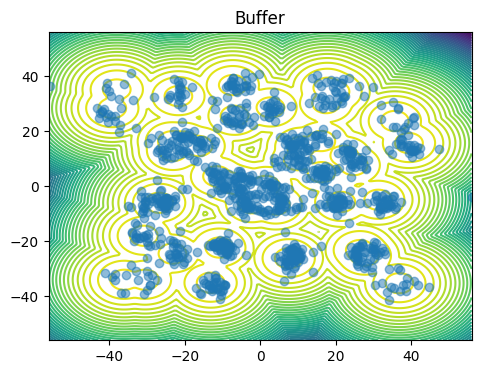

  5%|▌         | 5/100 [00:41<13:05,  8.27s/it]

Epoch 5 | Time 0.000000 | Loss -92.565216
Epoch 5 | Time 0.001953 | Loss -104.304504
Epoch 5 | Time 0.003906 | Loss -125.045250
Epoch 5 | Time 0.005859 | Loss -151.471802
Epoch 5 | Time 0.007812 | Loss -181.166733
Epoch 5 | Time 0.009766 | Loss -207.467453
Epoch 5 | Time 0.011719 | Loss -221.248413
Epoch 5 | Time 0.013672 | Loss -221.493103
Epoch 5 | Time 0.015625 | Loss -210.069412
Epoch 5 | Time 0.017578 | Loss -192.363220
Epoch 5 | Time 0.019531 | Loss -173.557770
Epoch 5 | Time 0.021484 | Loss -171.943146
Epoch 5 | Time 0.023438 | Loss -138.805939
Epoch 5 | Time 0.025391 | Loss -116.237587
Epoch 5 | Time 0.027344 | Loss -98.831627
Epoch 5 | Time 0.029297 | Loss -95.826843
Epoch 5 | Time 0.031250 | Loss -106.333763
Epoch 5 | Time 0.033203 | Loss -99.941101
Epoch 5 | Time 0.035156 | Loss -85.686287
Epoch 5 | Time 0.037109 | Loss -72.424515
Epoch 5 | Time 0.039062 | Loss -85.766129
Epoch 5 | Time 0.041016 | Loss -81.390762
Epoch 5 | Time 0.042969 | Loss -67.558197
Epoch 5 | Time 0.044

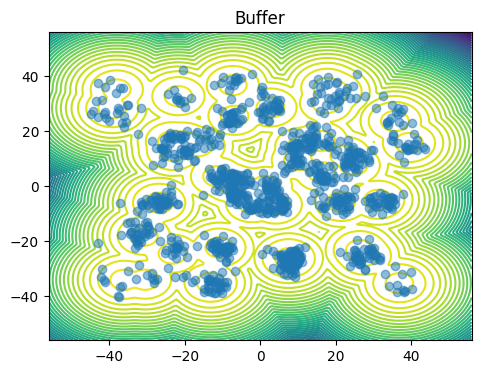

  6%|▌         | 6/100 [00:49<12:56,  8.26s/it]

Epoch 6 | Time 0.000000 | Loss -88.992752
Epoch 6 | Time 0.001953 | Loss -97.954758
Epoch 6 | Time 0.003906 | Loss -117.619034
Epoch 6 | Time 0.005859 | Loss -145.717194
Epoch 6 | Time 0.007812 | Loss -180.666595
Epoch 6 | Time 0.009766 | Loss -216.674515
Epoch 6 | Time 0.011719 | Loss -244.798523
Epoch 6 | Time 0.013672 | Loss -246.300522
Epoch 6 | Time 0.015625 | Loss -237.151871
Epoch 6 | Time 0.017578 | Loss -229.001450
Epoch 6 | Time 0.019531 | Loss -197.052109
Epoch 6 | Time 0.021484 | Loss -193.745224
Epoch 6 | Time 0.023438 | Loss -159.397583
Epoch 6 | Time 0.025391 | Loss -126.130646
Epoch 6 | Time 0.027344 | Loss -123.067383
Epoch 6 | Time 0.029297 | Loss -115.432686
Epoch 6 | Time 0.031250 | Loss -91.171227
Epoch 6 | Time 0.033203 | Loss -90.390518
Epoch 6 | Time 0.035156 | Loss -87.879791
Epoch 6 | Time 0.037109 | Loss -81.978989
Epoch 6 | Time 0.039062 | Loss -85.031151
Epoch 6 | Time 0.041016 | Loss -78.163803
Epoch 6 | Time 0.042969 | Loss -70.917435
Epoch 6 | Time 0.044

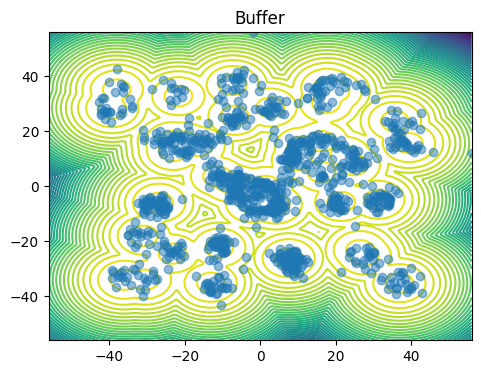

  7%|▋         | 7/100 [00:58<12:52,  8.31s/it]

Epoch 7 | Time 0.000000 | Loss -110.735291
Epoch 7 | Time 0.001953 | Loss -120.542091
Epoch 7 | Time 0.003906 | Loss -137.247803
Epoch 7 | Time 0.005859 | Loss -168.512024
Epoch 7 | Time 0.007812 | Loss -201.475891
Epoch 7 | Time 0.009766 | Loss -222.393585
Epoch 7 | Time 0.011719 | Loss -243.748459
Epoch 7 | Time 0.013672 | Loss -242.204193
Epoch 7 | Time 0.015625 | Loss -221.871246
Epoch 7 | Time 0.017578 | Loss -184.917969
Epoch 7 | Time 0.019531 | Loss -168.666382
Epoch 7 | Time 0.021484 | Loss -165.183395
Epoch 7 | Time 0.023438 | Loss -169.991104
Epoch 7 | Time 0.025391 | Loss -143.870773
Epoch 7 | Time 0.027344 | Loss -90.397858
Epoch 7 | Time 0.029297 | Loss -77.563950
Epoch 7 | Time 0.031250 | Loss -63.941597
Epoch 7 | Time 0.033203 | Loss -75.502007
Epoch 7 | Time 0.035156 | Loss -84.169647
Epoch 7 | Time 0.037109 | Loss -65.012413
Epoch 7 | Time 0.039062 | Loss -59.388081
Epoch 7 | Time 0.041016 | Loss -70.298889
Epoch 7 | Time 0.042969 | Loss -72.695511
Epoch 7 | Time 0.044

  7%|▋         | 7/100 [01:01<13:34,  8.76s/it]

Epoch 7 | Time 0.222656 | Loss -11.859331
Epoch 7 | Time 0.224609 | Loss -9.345392
Epoch 7 | Time 0.226562 | Loss -10.697816
Epoch 7 | Time 0.228516 | Loss -10.081516
Epoch 7 | Time 0.230469 | Loss -11.135004
Epoch 7 | Time 0.232422 | Loss -10.376232
Epoch 7 | Time 0.234375 | Loss -10.400795
Epoch 7 | Time 0.236328 | Loss -11.084609
Epoch 7 | Time 0.238281 | Loss -10.520174
Epoch 7 | Time 0.240234 | Loss -10.044592
Epoch 7 | Time 0.242188 | Loss -9.940788
Epoch 7 | Time 0.244141 | Loss -10.604586
Epoch 7 | Time 0.246094 | Loss -10.189076
Epoch 7 | Time 0.248047 | Loss -9.869217


KeyboardInterrupt: 

In [9]:
epsilon = 1e-6
reverse_ode = ReverseODE(vectorfield, noise_schedule, prior=prior, target=target, clipper=clipper, schedule=schedule)
num_samples = 1_024
outer_epochs = 100
inner_epochs = 2
beta = 1.0

for epoch in tqdm(range(outer_epochs)):
    target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)

    total_loss = 0.
    start_time = torch.tensor(0.0).to(device)
    delta = t_end - start_time
    num_integration_steps = int(torch.abs(delta) / dt)
    times = torch.linspace(start_time, t_end, num_integration_steps + 1)[:-1]
    indices = torch.arange(times.shape[0]).to(device)
    langevin_sde = LangevinSDE(beta=beta, prior=prior, target=target, vel=vectorfield, clipper=clipper, schedule=schedule)
    x_gen = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_024, compute_weight=False).detach()
    
    for i, t in zip(indices, times):
            optimizer.zero_grad()
            x = x_gen[i].to(device).detach()
            t = t.to(device).detach()
            loss = compute_pf_loss(x, t, schedule, target, prior, vectorfield)
            loss = loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            print("Epoch %d | Time %f | Loss %f" % (epoch, t.item(), loss.item()))

    # Generate samples using the network
    samples = generate_samples_ode(reverse_ode, 1_024)
    samples_energy = target(samples)
    target.get_dataset_fig(target.unnormalize(samples))
    plt.show()


In [ ]:
target = GMM(dimensionality=2,
            n_mixes=40,
            loc_scaling= 40,
            log_var_scaling=1.0,
            device=device,
            should_unnormalize=True)
reverse_ode = ReverseODE(vectorfield, noise_schedule, prior=prior, target=target, clipper=clipper, schedule=schedule, resample_threshold=0.98)

dt = torch.tensor(1.0 / 512).to(device)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
# samples = reverse_ode.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=1_000, compute_weight=False)[-1]
samples = generate_samples_ode(reverse_ode, 1_024)
samples_energy = target(samples)
target.get_dataset_fig(target.unnormalize(samples))
plt.show()

In [ ]:
target = GMM(dimensionality=2,
            n_mixes=40,
            loc_scaling= 40,
            log_var_scaling=1.0,
            device=device,
            should_unnormalize=True)
langevin_sde = LangevinSDE(beta=beta, prior=prior, target=target, clipper=clipper, vel=vectorfield, schedule=schedule)

dt = torch.tensor(1.0 / 512).to(device)
t_init,t_end = torch.tensor(0.0).to(device), torch.tensor(1.0).to(device)
samples = langevin_sde.sample(x0=None, dt=dt, end_time=t_end, device=device, num_samples=5_000, compute_weight=True)
samples_energy = target(samples[-1])
target.get_dataset_fig(target.unnormalize(samples[-1]))
plt.show()